In [30]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
# import PIL 
import gc
# import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import cohen_kappa_score, accuracy_score
# from tensorflow import set_random_seed
# from tqdm import tqdm
# from math import ceil

import keras
# from keras.preprocessing import image
from keras.models import Model
# from keras.models import Sequential, Model
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Input, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu, sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
ZOOM         = 0.85
NUM_CLASSES  = 5

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}


# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
df_2019.id_code = df_2019.id_code.apply(lambda x: "modified_" + x) 
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")
df_2015["id_code"]   = df_2015.image
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)




5537


Text(0.5, 1.0, 'Samples Per Class')

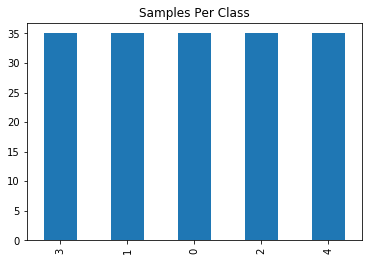

In [33]:
class_to_val = [[0.85, 0.1, 0.05, 0, 0],
                [0.1, 0.8, 0.1, 0, 0],
                [0, 0.15, 0.7, 0.15, 0],
                [0, 0, 0.1, 0.8, 0.1], 
                [0, 0, 0.05, 0.1, 0.85]]

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    for i in range(5):
        train[str(i)] = train.diagnosis.apply(lambda x: class_to_val[x][i])
        valid[str(i)] = valid.diagnosis.apply(lambda x: class_to_val[x][i])

    train.diagnosis = train.diagnosis.astype('str')
    valid.diagnosis = valid.diagnosis.astype('str')

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == str(diagnosis)].index
            indexes_train = train[train['diagnosis'] == str(diagnosis)].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution later, and take a smaller batch if the train size is larger than 10000
    frac = 1
    print(train.size)
    if train.size > 10000:
        frac = 10000/train.size
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

# plot example
_, df_to_plot = get_train_valid_df(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')

# df_to_plot.columns

5537


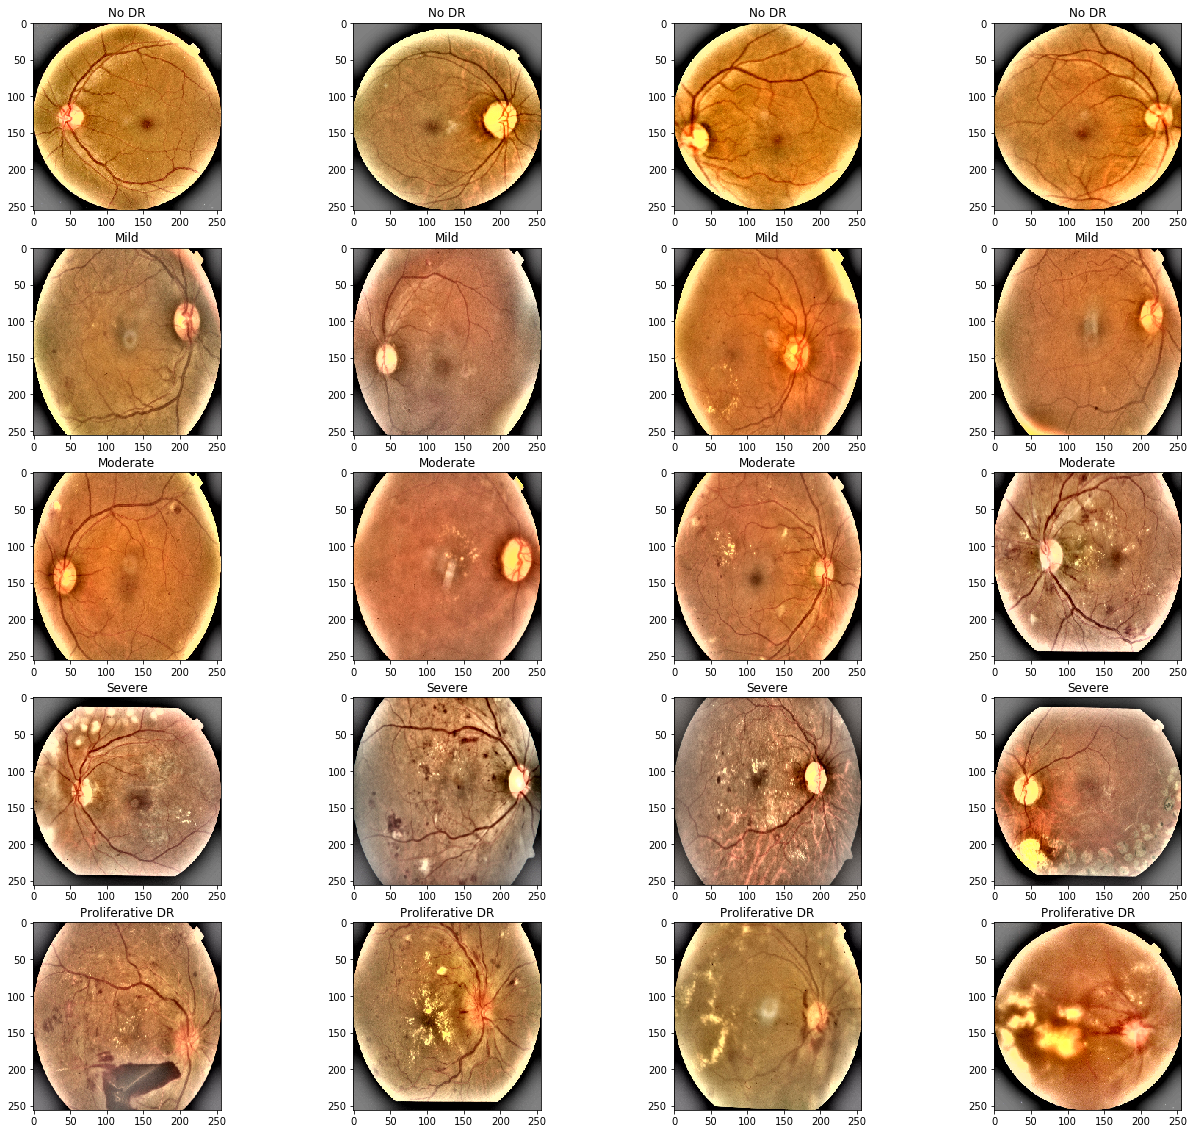

In [34]:
# display some data
df_example, _ = get_train_valid_df(year="2019")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_example['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
                                    .sample(4)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        

In [35]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True, 
                                       vertical_flip=True,
                                       rotation_range=360,
                                       zoom_range=[(1-jitter)*ZOOM, (1+jitter)*ZOOM],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", class_mode="raw",
                                       y_col=["0", "1", "2", "3", "4"],
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019"):
    
    train, valid = get_train_valid_df(year=year) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


34735

Found 795 validated image filenames.
Found 170 validated image filenames.


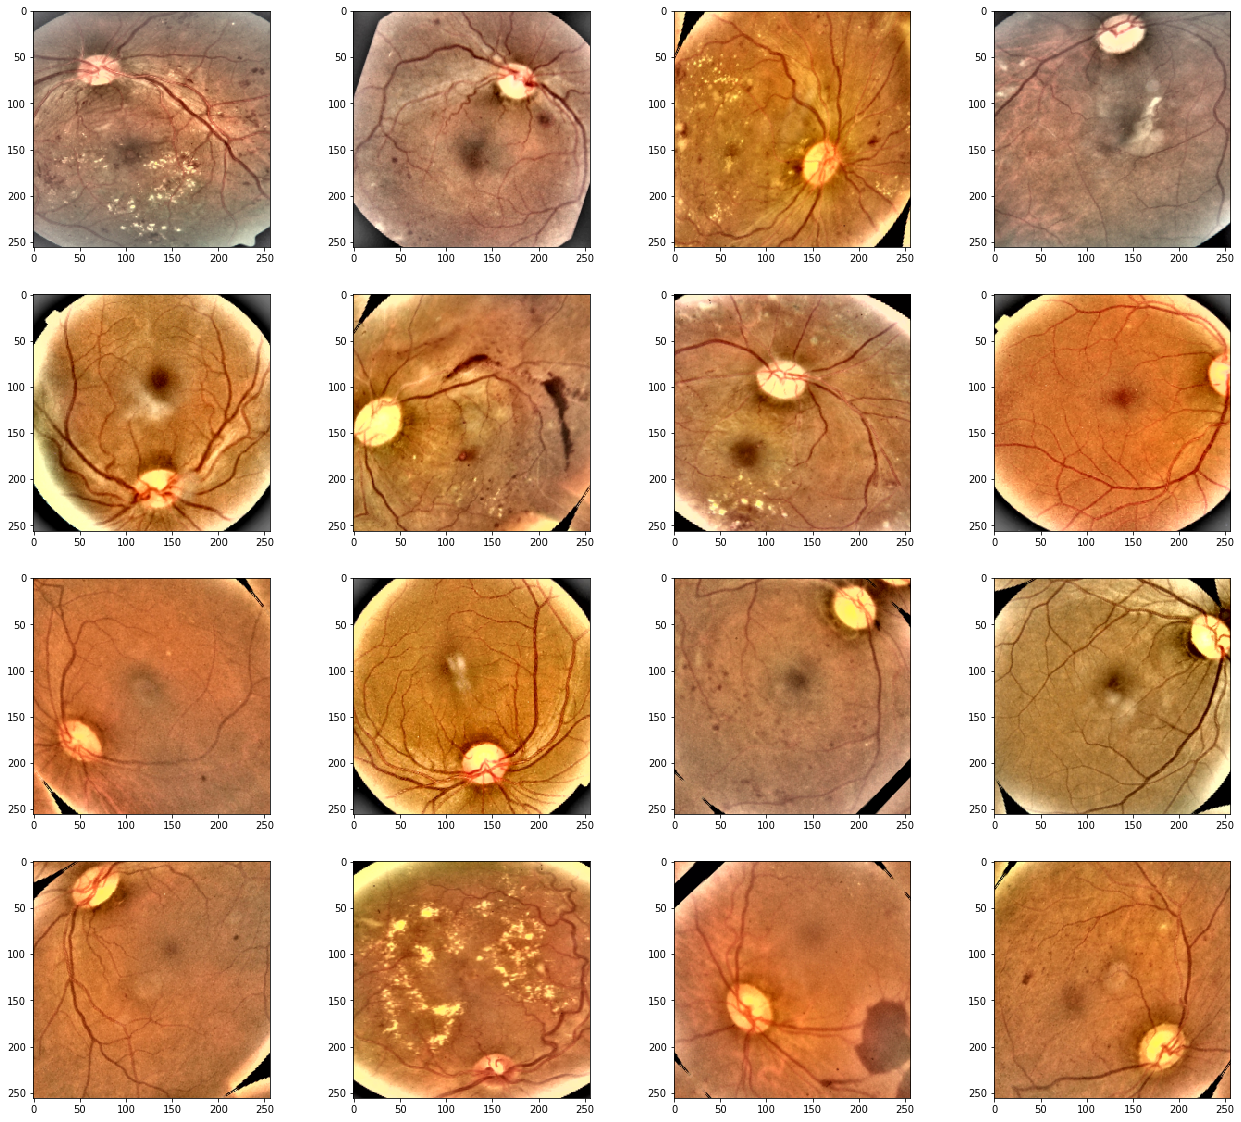

In [22]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [38]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        predict_val = model.predict_generator(self.generator, 
                                              steps=self.generator.n//self.generator.batch_size, 
                                              verbose=1)
        numBatches = 5
        val_kappa  = 0
        for x, y in self.generator:
            predictions = model.predict(x)
            y_pred = np.argmax(predictions, axis=1)
            y_val  = np.argmax(y, axis=1)
            val_kappa += cohen_kappa_score(y_val, y_pred, weights='quadratic')/5
            
            numBatches -= 1
            if numBatches == 0:
                break
            
#         print(y_val[:5], predictions[:5])

            
        self.val_kappas.append(val_kappa)
        print(f"val_kappa: {val_kappa:.4f}")

        if val_kappa == max(self.val_kappas) and val_kappa > 0.8:
            print("Max of this run, saving model.")
            model.save(f"densenet_new-{val_kappa:.4f}.h5")


In [15]:
def create_model(img_dim, CHANNELS, n_class):
    
    input_tensor = Input(shape=(img_dim, img_dim, CHANNELS))
    base_model   = DenseNet121(weights=None, include_top=False, input_tensor=input_tensor)
    #base_model.load_weights('../DenseNet-BC-121-32-no-top.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512,  activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model = Model(input_tensor, output_layer)
    
    return model

model = create_model(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)
# model.load_weights("densenet_new-0.3916.h5") 



In [ ]:
 for trial in range(5):
    
    model.compile(optimizer=Adam(lr=0.00005), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
    
    for year in ["2019", "2015", "2019", "2015"]:

        # these need to be global for the kappa callback
        train_generator, valid_generator = generator(jitter=0.1, year=year)

        # Call backs during training            
        kappa_callbacks = Metrics(valid_generator)
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
        reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                       min_lr=1e-7, mode='auto', verbose=1)

        # train the model for 12 epochs
        history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                      validation_data=valid_generator,
                                      validation_steps=valid_generator.n // valid_generator.batch_size,
                                      epochs=4,
                                      callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                      verbose=1
                                     )
    
    gc.collect()

5537
Found 791 validated image filenames.
Found 175 validated image filenames.
Epoch 1/4
5/5 [==============================] - 14s 3s/step
val_kappa: 0.6279
Epoch 2/4
5/5 [==============================] - 4s 765ms/step
val_kappa: 0.7328
Epoch 3/4
5/5 [==============================] - 4s 767ms/step
val_kappa: 0.7390
Epoch 4/4
5/5 [==============================] - 3s 597ms/step
val_kappa: 0.7851
25470
Found 1111 validated image filenames.
Found 279 validated image filenames.
Epoch 1/4
8/8 [==============================] - 5s 677ms/step
val_kappa: 0.6186
Epoch 2/4
8/8 [==============================] - 6s 691ms/step
val_kappa: 0.6497
Epoch 3/4
8/8 [==============================] - 6s 735ms/step
val_kappa: 0.7093
Epoch 4/4
8/8 [==============================] - 6s 726ms/step
val_kappa: 0.7223
5537
Found 791 validated image filenames.
Found 175 validated image filenames.
Epoch 1/4
5/5 [==============================] - 3s 637ms/step
val_kappa: 0.7174
Epoch 2/4
5/5 [===================

5/5 [==============================] - 3s 661ms/step
val_kappa: 0.8066
25470
Found 1111 validated image filenames.
Found 279 validated image filenames.
Epoch 1/4
8/8 [==============================] - 5s 660ms/step
val_kappa: 0.6859
Epoch 2/4
8/8 [==============================] - 6s 721ms/step
val_kappa: 0.7192
Epoch 3/4
8/8 [==============================] - 6s 751ms/step
val_kappa: 0.6285
Epoch 4/4
8/8 [==============================] - 6s 730ms/step
val_kappa: 0.8095
Max of this run, saving model.
5537
Found 791 validated image filenames.
Found 175 validated image filenames.
Epoch 1/4
5/5 [==============================] - 3s 666ms/step
val_kappa: 0.7834
Epoch 2/4
5/5 [==============================] - 4s 732ms/step
val_kappa: 0.8103
Max of this run, saving model.
Epoch 3/4
5/5 [==============================] - 4s 780ms/step
val_kappa: 0.7451
Epoch 4/4
24/24 [==============================] - 28s 1s/step - loss: 0.0336 - acc: 0.7566 - val_loss: 0.0584 - val_acc: 0.6573

Epoch 0000